In [1]:
import tensorflow as tf

device_list = tf.test.gpu_device_name()
if device_list != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'. format(device_list))


Found GPU at: /device:GPU:0


In [2]:
# import  packages

import pandas as pd
import numpy as np

# load and mount the google drive
from google.colab import drive
drive.mount('/content/drive')

#Paths for the json data
REVIEW_PATH = '/content/drive/MyDrive/Colab Notebooks/yelp_reviews.csv'     # This has review text data with writer's user_id and the corresponding business_id that the review is written for.
BUSINESS_PATH = '/content/drive/MyDrive/Colab Notebooks/yelp_business.csv'  #with location data, attributes, and categories.
USER_PATH = '/content/drive/MyDrive/Colab Notebooks/yelp_user.csv' 

Mounted at /content/drive


In [3]:
#reading data from all csv files 

business_df = pd.read_csv(BUSINESS_PATH, low_memory = False)
user_df = pd.read_csv(USER_PATH, low_memory = False)
reviews_df = pd.read_csv(REVIEW_PATH, low_memory = False)

In [4]:
# import packages

import math
import itertools
import gc
import numpy as np
from math import sqrt
import string
import warnings
warnings.filterwarnings('ignore')

#imports for visualisations
import networkx as nx
import matplotlib.pyplot as plt

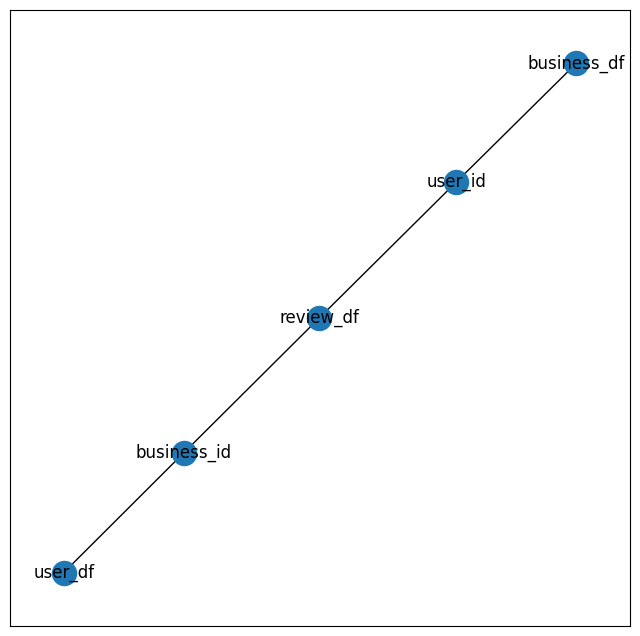

15

In [ ]:


#  relationship graph between user, business and reviews datasets
dnames = ['user_df', 'business_df', 'review_df']
G = nx.Graph()
fig, ax = plt.subplots(figsize=[8,8])
for n, d in zip(dnames, [business_df, user_df, reviews_df]):
    _ = []
    for c in np.intersect1d(d.columns, ['business_id', 'user_id']):
        _.append([n, c])
    G.add_edges_from(_, label=n)
nx.draw_networkx(G, ax=ax)
plt.show()
gc.collect()

In [5]:
# This library provides a unified interface for training and testing recommendation algorithms
!pip install surprise

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 772.0/772.0 KB 41.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.3-cp39-cp39-linux_x86_64.whl size=3195812 sha256=70cd9d3126b008091a6ff0b5b9b192b3b9d43a4c714c6f57f569fcc24730374d
  Stored in directory: /root/.cache/pip/wheels/c6/3a/46/9b17b3512bdf283c6cb84f59929cdd5199d4e754d596d22784
Successfully built scikit-surprise


In [6]:
# Python library used for generating word clouds from text and support stopwords
!pip install wordcloud


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [7]:

# importing libraries for natural language processing.
import nltk
from nltk.corpus import stopwords, wordnet
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from textblob import TextBlob, Word
from nltk.stem.wordnet import WordNetLemmatizer
from collections import Counter
from wordcloud import WordCloud


#importing libraries for modelling
import sklearn.metrics as metrics
# from sklearn.metrics.pairwise import linear_kernel, cosine_similarity
from sklearn.metrics import mean_squared_error
# from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.neighbors import NearestNeighbors
from scipy.spatial.distance import correlation, cosine

#importing libraries for evaluations and recommendations
from surprise import SVD, SVDpp, Dataset, accuracy, Reader, BaselineOnly, KNNBaseline
from surprise.model_selection import train_test_split, GridSearchCV, cross_validate

#importing pickle library
import pickle

In [8]:

# NLTK is an open-source toolkit for natural language processing.
nltk.download()


NLTK Downloader
---------------------------------------------------------------------------
    d) Download   l) List    u) Update   c) Config   h) Help   q) Quit
---------------------------------------------------------------------------
Downloader> d

Download which package (l=list; x=cancel)?
  Identifier> all


       | 
       | Downloading package abc to /root/nltk_data...
       |   Unzipping corpora/abc.zip.
       | Downloading package alpino to /root/nltk_data...
       |   Unzipping corpora/alpino.zip.
       | Downloading package averaged_perceptron_tagger to
       |     /root/nltk_data...
       |   Unzipping taggers/averaged_perceptron_tagger.zip.
       | Downloading package averaged_perceptron_tagger_ru to
       |     /root/nltk_data...
       |   Unzipping taggers/averaged_perceptron_tagger_ru.zip.
       | Downloading package basque_grammars to /root/nltk_data...
       |   Unzipping grammars/basque_grammars.zip.
       | Downloading package bcp47 to /root/nltk_data...
       | Downloading package biocreative_ppi to /root/nltk_data...
       |   Unzipping corpora/biocreative_ppi.zip.
       | Downloading package bllip_wsj_no_aux to /root/nltk_data...
       |   Unzipping models/bllip_wsj_no_aux.zip.
       | Downloading package book_grammars to /root/nltk_data...
       |   Un


---------------------------------------------------------------------------
    d) Download   l) List    u) Update   c) Config   h) Help   q) Quit
---------------------------------------------------------------------------
Downloader> q


True

**1. NAIVE BIAS ALGORITHM SENTIMENT ANALYSIS AND PREDICTION**

The objective is to develop a baseline model in which we just choose the review text and remove the punctuations before attempting to forecast the review rating using the Naive Bias Algorithm. This is assessed by examining the confusion matrix and classification report, which includes precision, recall, and f1-score.

In [9]:
# reviews text file's word count
reviews_df['word_count'] = reviews_df['text'].apply(lambda x: len(str(x).split(" ")))
reviews_df[['text','word_count']].head()

,text,word_count
0,Very good food here! Casual dining in the Don...,82
1,"The bar 33 is nice but restaurant overrated, h...",16
2,The place is located inside the new China Town...,121
3,Ordered Chicken Fried Rice. Rice was not fried...,22
4,The desserts and dinner are spectacular! Not ...,74


In [10]:
# Character count in the review text
reviews_df['char_count'] = reviews_df['text'].str.len() ## this also includes spaces
reviews_df[['text','char_count']].head()

,text,char_count
0,Very good food here! Casual dining in the Don...,422
1,"The bar 33 is nice but restaurant overrated, h...",105
2,The place is located inside the new China Town...,675
3,Ordered Chicken Fried Rice. Rice was not fried...,120
4,The desserts and dinner are spectacular! Not ...,404


In [11]:
# Average word length in the review text sentence
def avg_word(sentence):
  words = sentence.split()
  return (sum(len(word) for word in words)/len(words))

reviews_df['avg_word'] = reviews_df['text'].apply(lambda x: avg_word(x))
reviews_df[['text','avg_word']].head()
reviews_df['text'][1]

'The bar 33 is nice but restaurant overrated, had grilled redfish ....,twice....still raw on inside ,gross'

In [12]:
# Checking texts that starts with hashtags
reviews_df['hashtags'] = reviews_df['text'].apply(lambda x: len([x for x in x.split() if x.startswith('#')]))
reviews_df[['text','hashtags']].head()

,text,hashtags
0,Very good food here! Casual dining in the Don...,0
1,"The bar 33 is nice but restaurant overrated, h...",0
2,The place is located inside the new China Town...,0
3,Ordered Chicken Fried Rice. Rice was not fried...,0
4,The desserts and dinner are spectacular! Not ...,0


In [13]:
# Count of stopwords present in the review text
stop = stopwords.words('english')

reviews_df['stopwords'] = reviews_df['text'].apply(lambda x: len([x for x in x.split() if x in stop]))
reviews_df[['text','stopwords']].head()

,text,stopwords
0,Very good food here! Casual dining in the Don...,33
1,"The bar 33 is nice but restaurant overrated, h...",4
2,The place is located inside the new China Town...,53
3,Ordered Chicken Fried Rice. Rice was not fried...,7
4,The desserts and dinner are spectacular! Not ...,23


In [ ]:
# Top 10 frequent words
freq_top = pd.Series(' '.join(reviews_df['text']).split()).value_counts()[:10]
freq_top

the    2994555
and    2514200
a      1787924
I      1680792
to     1567406
was    1382542
of     1026715
is      863368
for     787857
The     733287
dtype: int64

In [ ]:
# Least 10 frequent words
freq_least = pd.Series(' '.join(reviews_df['text']).split()).value_counts()[-10:]
freq_least

outstanding........place    1
Reginelli's,                1
Kebba                       1
special...10                1
typical/standard            1
waistline!)                 1
14+,                        1
"straight-up")              1
Daiquiri."                  1
wursthen,                   1
dtype: int64

In [14]:
# Includig the text length column in review dataset
reviews_df['text length'] = reviews_df['text'].apply(len)
reviews_df.head()

,review_id,user_id,business_id,stars,useful,funny,cool,text,date,word_count,char_count,avg_word,hashtags,stopwords,text length
0,LEt_rcvZ9UsAhQCRGRBkVQ,55859.0,57066.0,4.0,1,1,0,Very good food here! Casual dining in the Don...,2017-05-12 23:58:29,82,422,4.371795,0,33,422
1,K4gdzC3ut1SJAkHWR_YGQQ,913166.0,57082.0,1.0,0,0,0,"The bar 33 is nice but restaurant overrated, h...",2016-05-15 05:00:45,16,105,5.625000,0,4,105
2,7hGVG9nUzhpiiSAniPDTbg,51384.0,52530.0,3.0,2,0,2,The place is located inside the new China Town...,2017-04-06 23:17:53,121,675,4.395161,0,53,675
3,1z_2diaMLhSkc0z4L0BxnQ,415994.0,55602.0,2.0,3,0,0,Ordered Chicken Fried Rice. Rice was not fried...,2018-11-27 02:18:43,22,120,4.714286,0,7,120
4,-pMqa4mXtbsT0VYePB5xHA,1489292.0,57703.0,5.0,1,0,0,The desserts and dinner are spectacular! Not ...,2019-04-28 02:50:57,74,404,5.171875,0,23,404


**We remove punctuation from the text and apply the Naive Bias algorithm to forecast user ratings based on the reviews.**

In [15]:
# separating our features and target
X = reviews_df['text']
y = reviews_df['stars']

In [16]:
# function to remove only punctuations from the review text
def text_process(text):

    '''
    Takes in a string of text, then performs the following:
    1. Removes all punctuation
    2. Return the text as a list of words
    '''

    nopunc = [char for char in text if char not in string.punctuation]

    nopunc = ''.join(nopunc)
    
    return [word for word in nopunc.split()]

# Let us test the function 
sample_text = "Hello! Lets test this, see what happens."

print(text_process(sample_text))

['Hello', 'Lets', 'test', 'this', 'see', 'what', 'happens']


In [17]:
# creating a bag of words which consist of entire text without punctuations and fiting it
bow_transformer = CountVectorizer().fit(X)

# Looking for the count of features
len(bow_transformer.vocabulary_)

159150

In [18]:
# transform our review text
#%%time
X = bow_transformer.transform(X)
print('Shape of Sparse Matrix: ', X.shape)
print('Amount of Non-Zero occurrences: ', X.nnz)

# Percentage of non-zero values
density = (100.0 * X.nnz / (X.shape[0] * X.shape[1]))
print('Density: {}'.format((density)))

Shape of Sparse Matrix:  (715569, 159150)
Amount of Non-Zero occurrences:  47164540
Density: 0.04141497870630934


In [19]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)
print("Number transactions X_train dataset: ", X_train.shape)
print("Number transactions y_train dataset: ", y_train.shape)
print("Number transactions X_test dataset: ", X_test.shape)
print("Number transactions y_test dataset: ", y_test.shape)

Number transactions X_train dataset:  (500898, 159150)
Number transactions y_train dataset:  (500898,)
Number transactions X_test dataset:  (214671, 159150)
Number transactions y_test dataset:  (214671,)


In [20]:
print("Before OverSampling, counts of label '1': {}".format(sum(y_train==1)))
print("Before OverSampling, counts of label '2': {}".format(sum(y_train==2)))
print("Before OverSampling, counts of label '3': {}".format(sum(y_train==3)))
print("Before OverSampling, counts of label '4': {}".format(sum(y_train==4)))
print("Before OverSampling, counts of label '5': {} \n".format(sum(y_train==5)))

sm = SMOTE(random_state=2)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train.ravel())

print('After OverSampling, the shape of train_X: {}'.format(X_train_res.shape))
print('After OverSampling, the shape of train_y: {} \n'.format(y_train_res.shape))

print("After OverSampling, counts of label '1': {}".format(sum(y_train_res==1)))
print("After OverSampling, counts of label '2': {}".format(sum(y_train_res==2)))
print("After OverSampling, counts of label '3': {}".format(sum(y_train_res==3)))
print("After OverSampling, counts of label '4': {}".format(sum(y_train_res==4)))
print("After OverSampling, counts of label '5': {}".format(sum(y_train_res==5)))


Before OverSampling, counts of label '1': 63840
Before OverSampling, counts of label '2': 41079
Before OverSampling, counts of label '3': 53681
Before OverSampling, counts of label '4': 112022
Before OverSampling, counts of label '5': 230276 

After OverSampling, the shape of train_X: (1151380, 159150)
After OverSampling, the shape of train_y: (1151380,) 

After OverSampling, counts of label '1': 230276
After OverSampling, counts of label '2': 230276
After OverSampling, counts of label '3': 230276
After OverSampling, counts of label '4': 230276
After OverSampling, counts of label '5': 230276


In [21]:
# Let us now train the model using Multinomial Naive Bais Algorithm
from sklearn.naive_bayes import MultinomialNB

nb = MultinomialNB()
nb.fit(X_train, y_train)

MultinomialNB()

In [22]:
# export the model into pickle file

end_model = open("Naive_Bais_Model_sentiment.pkl", "wb")
pickle.dump(nb, end_model)

In [23]:
# predict the test set
nb_preds = nb.predict(X_test)
nb_prob = nb.predict_proba(X_test)

Confusion Matrix of the Naive Bayes


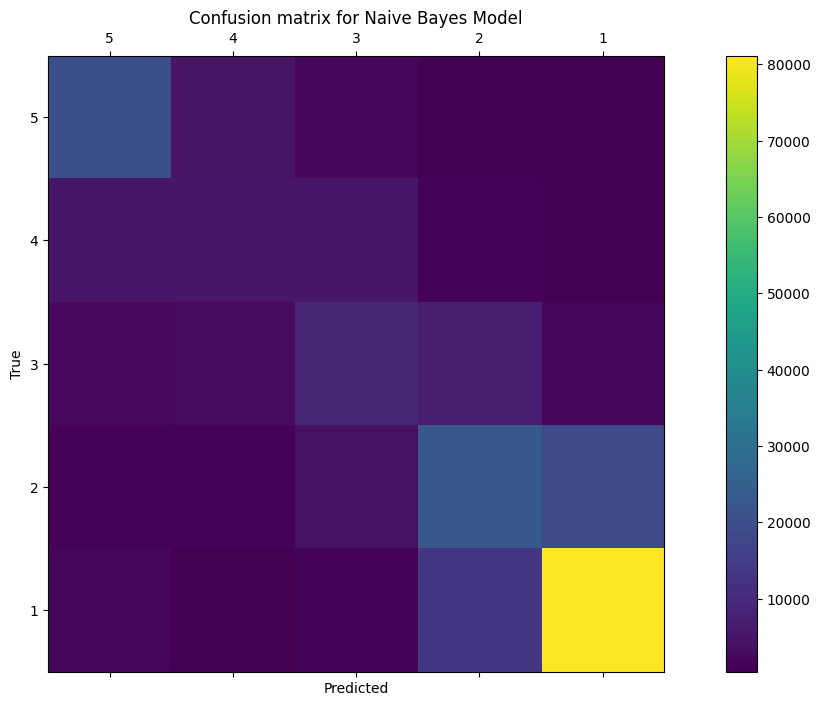

In [24]:
# Let us now evaluate and plot Confusion Matrix 

labels = [5,4,3,2,1]
nb_cm = confusion_matrix(y_test, nb_preds)
print('Confusion Matrix of the Naive Bayes')
fig = plt.figure(figsize=(16,8))
ax = fig.add_subplot(111)
cax = ax.matshow(nb_cm)
plt.title('Confusion matrix for Naive Bayes Model')
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [25]:
# evaluate the model using classification report
nb_cr = classification_report(y_test, nb_preds)
print('               Classification Report for Naive Bayes\n')
print(nb_cr)

               Classification Report for Naive Bayes

              precision    recall  f1-score   support

         1.0       0.65      0.74      0.69     27393
         2.0       0.36      0.29      0.33     17838
         3.0       0.42      0.38      0.40     23163
         4.0       0.50      0.47      0.49     47999
         5.0       0.79      0.83      0.81     98278

    accuracy                           0.64    214671
   macro avg       0.54      0.54      0.54    214671
weighted avg       0.63      0.64      0.64    214671



Note that the results for 3 and 4 star ratings are sub-optimal, indicating that the model is not very good and that there is a high chance that it would forecast the ratings incorrectly.

In [26]:
# Let us now calculate accuracy score
nb_acc = metrics.accuracy_score(y_test, nb_preds)
print("Accuracy Score of Naive Bayes Model")
print(nb_acc)

Accuracy Score of Naive Bayes Model
0.6435103018106777


In [ ]:
reviews_df.tail()


,review_id,user_id,business_id,stars,useful,funny,cool,text,date,word_count,char_count,avg_word,hashtags,stopwords,text length
715564,7NgXAuTFiJHYbuepOPwU0w,35283.0,61243.0,5.0,1,0,1,Don't misinterpret my 5-star review....I don't...,2016-04-30 01:02:34,167,890,4.248521,0,63,890
715565,wD5ZWao_vjyT2h4xmGam8Q,46895.0,58730.0,5.0,1,0,1,It is very rare for a restaurant to be this go...,2022-01-17 22:36:01,64,336,4.333333,0,31,336
715566,YVX1Wsa4LYxjvFwuHBb_gA,55742.0,60092.0,4.0,3,0,2,"Good, maybe very good. I went for lunch, so t...",2015-01-23 23:52:03,518,2700,4.317365,0,203,2700
715567,i-I4ZOhoX70Nw5H0FwrQUA,199546.0,59713.0,5.0,1,0,0,For when I'm feeling like ignoring my calorie-...,2022-01-19 18:59:27,378,2317,5.095238,0,121,2317
715568,RwcKOdEuLRHNJe4M9-qpqg,207165.0,63554.0,3.0,10,3,7,Located in the 'Walking District' in Nashville...,2018-01-02 22:50:47,212,1198,4.627358,0,87,1198


In [ ]:
from random import randint
def predict_reviews_df(n,bow_transformer,nb,reviews_df):
    value = randint(0,n)
    print('The row that has been selected is', value)
    review_verdict = reviews_df['text'][value]
    review_verdict_transformed = bow_transformer.transform([review_verdict])
    predicted_rating = nb.predict(review_verdict_transformed)[0]
    columns_df = pd.DataFrame(columns=reviews_df.columns)
    columns_df.loc[0] = reviews_df.iloc[value]
    columns_df['Predicted'] = predicted_rating
    return columns_df
predict_reviews_df(55,bow_transformer,nb,reviews_df)

The row that has been selected is 52


,review_id,user_id,business_id,stars,useful,funny,cool,text,date,word_count,char_count,avg_word,Predicted
0,7H8WNEupKHvcxR5xCJKJ_A,41270.0,57172.0,4.0,1,3,1,"I was just introduced to this longstanding, lo...",2013-11-08 18:21:14,388,1955,4.284153,4.0


As indicated in the table above, the predicted rating for this review is 5 which is identical to the actual review rating. 

In [27]:
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV

In [28]:
classifier = LinearSVC()
clf = CalibratedClassifierCV(classifier) 

clf.fit(X_train,y_train)

KeyboardInterrupt: ignored

In [ ]:
end_model2 = open("SVM_Classifier.pkl", "wb")
pickle.dump(classifier, end_model2)

In [ ]:
svm_preds = clf.predict(X_test)
svm_prob = clf.predict_proba(X_test)

In [ ]:
#  evaluate and plot Confusion Matrix 

labels = [5,4,3,2,1]
svm_cm = confusion_matrix(y_test, svm_preds, labels)
print('Confusion matrix of the SVM Classifier \n\n',svm_cm,'\n')
fig = plt.figure(figsize=(16,8))
ax = fig.add_subplot(111)
cax = ax.matshow(svm_cm)
plt.title('Confusion matrix of the SVM Classifier')
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [ ]:
# Let us now evaluate our model using classification report
svm_cr = classification_report(y_test, svm_preds)
print('                SVM Classifier's Classification Report \n')

print(svm_cr)

In [ ]:
# calculate accuracy score
svm_acc = metrics.accuracy_score(y_test, svm_preds)
print("Accuracy Score of SVM Classifier\n")
print(svm_acc)

In [ ]:
# import Random Forest library
from sklearn.ensemble import RandomForestClassifier

In [ ]:
# Generate a random forest Classifier
rand_clf = RandomForestClassifier(n_jobs=2, random_state=0)

# Allow Classifier to be trained 

rand_clf.fit(X_train,y_train)

